In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

from functions import transform_raw_data, clean_df, impute_fit_df, impute_transform_df

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

In [9]:
features = ['age_of_casualty','engine_capacity_cc','age_of_driver',
            'vehicle_type','vehicle_subtype','junction_detail','towing_and_articulation','vehicle_manoeuvre',
            'casualty_imd_decile','pedestrian_crossing_physical_facilities','pedestrian_crossing_human_control','driver_imd_decile',
            'day_of_week','time_period','season',
            'first_road_class','road_type','speed_limit','junction_control','second_road_class',
            'light_conditions','weather_conditions','road_surface_conditions','propulsion_code','sex_of_casualty','sex_of_driver',
            'urban_or_rural_area','casualty_home_area_type','first_point_of_impact','junction_location','vehicle_location_restricted_lane'
            #,'T2M','RH2M','PRECTOTCORR','WS2M','log_PRECTOTCORR'
            ]

In [10]:
df = transform_raw_data(path_to_csv="stats19CycleCollisions2022.csv")
#df["log_PRECTOTCORR"] = np.log(df["PRECTOTCORR"] + 0.001)
df = df[features + ['casualty_severity']]
df = clean_df(df)
df['fatality'] = np.where(df['casualty_severity'] == "Fatal", 1, 0)
target = 'fatality'
df = df[~df.isin(['Missing']).any(axis=1)]
df["vehicle_type_2"] = [
            "Goods over 3.5t. and under 7.5t" if vehicle_type in ["Agricultural vehicle", "Goods vehicle - unknown weight"]
            else "Motorcycle 50cc and under" if vehicle_type == "Electric motorcycle"
            else "Motorcycle 125cc and under" if vehicle_type == "Motorcycle - unknown cc"
            else "Car" if vehicle_type == "Unknown vehicle type (self rep only)"
            else vehicle_type
            for vehicle_type in df["vehicle_type"]
    ]
engine_capacity_car = df.groupby("vehicle_type_2")["engine_capacity_cc"].median().loc["Car"]
df["engine_capacity_cc"] = np.where(df["vehicle_type"] == "Pedal cycle", 0.00065 * engine_capacity_car, df["engine_capacity_cc"])
df['log_engine_capacity_cc'] = np.log(df['engine_capacity_cc'] + 0.0000001)
features = ['log_engine_capacity_cc'] + features
df.dropna(axis=0, inplace=True)

c:\Users\danjr\Documents\Projects\cycle collisions\functions.py:6: DtypeWarning: Columns (0,2,39,72) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_csv, header=0)


In [12]:
# plotting correlation between features and the target
def is_continuous(series):
    return pd.api.types.is_numeric_dtype(series)

# function assumes that continuous variables are listed before categorical columns in the 'columns' input
def plot_correlation_grid(df, features, num_cols=3):
    num_plots = len(features)
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 40))
    ax = ax.flatten()
    
    # get all pairs of variables to plot
    plotted_pairs = 0
    max_plots = num_rows * num_cols

    # trimming category labels to make the charts easier to read
    df_trimmed = df.applymap(lambda x: x[:20] if isinstance(x, str) else x)
    
    for feature in features:

        ax_sub = ax[plotted_pairs]
        
        # if feature is continuous, create a violin plot
        if is_continuous(df_trimmed[feature]):
            sns.violinplot(df_trimmed, x=feature, y=target, ax=ax_sub, orient='h')
        else:
            df_trimmed.groupby(target)[feature].value_counts(normalize=True).unstack().transpose().plot(kind='bar', ax=ax_sub)

        ax_sub.set_title(f'{feature} vs {target}')
        ax_sub.xaxis.set_ticks(ax_sub.get_xticks()) # add this line to avoid warning
        ax_sub.set_xticklabels(ax_sub.get_xticklabels(), rotation=45, ha='right')
        plotted_pairs += 1
                
        if plotted_pairs >= max_plots:
            break

    for j in range(num_rows * num_cols):
        if j > plotted_pairs - 1:
            fig.delaxes(ax[j])
    
    plt.tight_layout()
    plt.show()

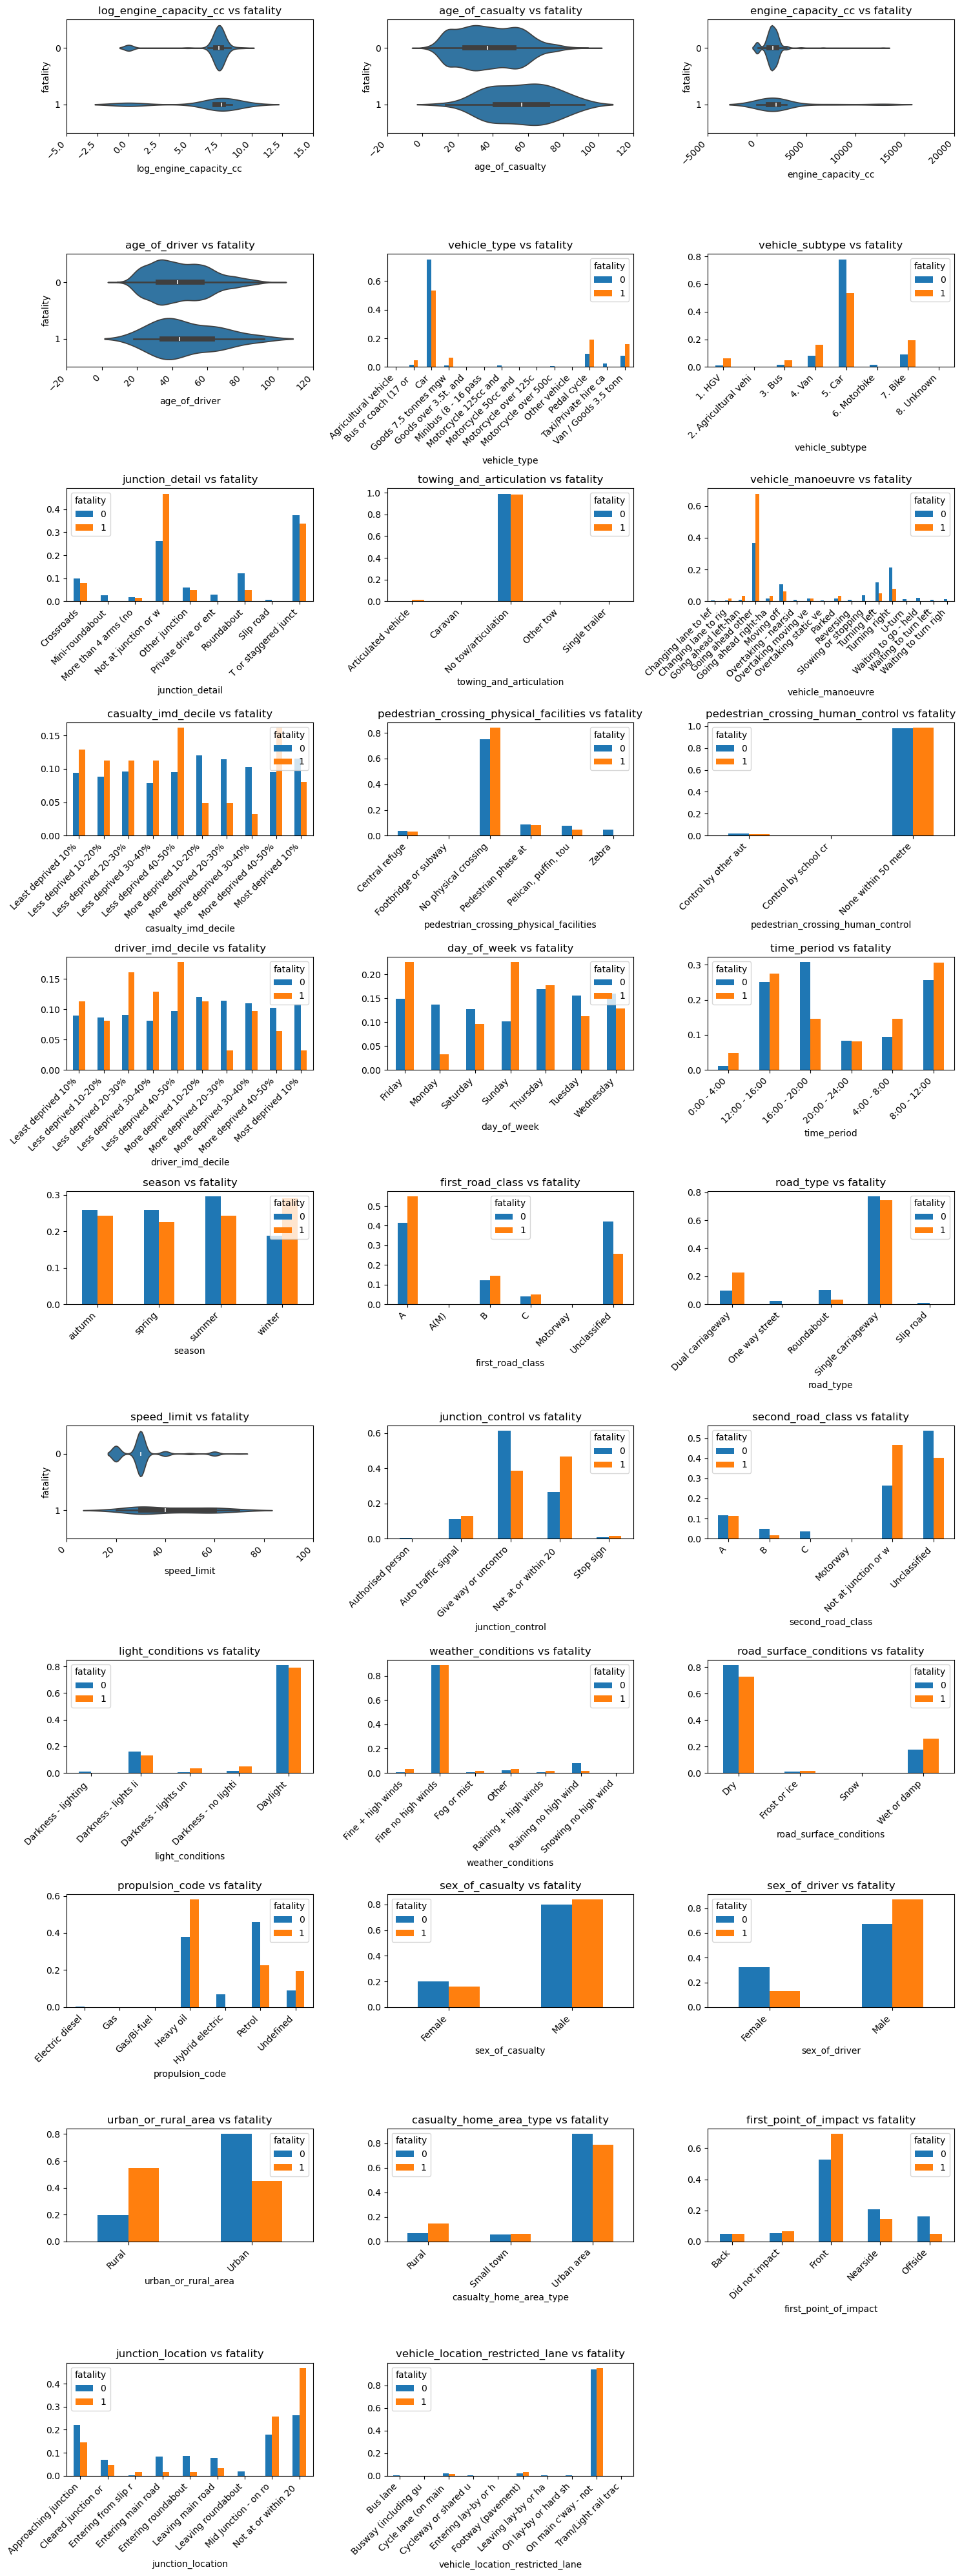

In [13]:
categorical_features = [col for col in df.select_dtypes(include='object').columns.to_list() if col in features]

plot_correlation_grid(df, features)